<a href="https://colab.research.google.com/github/Aswani-ReddyKV/Capstone_Sentiment_Recommendation/blob/main/Aswani_Reddy_Sentiment_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [126]:
# install required packages
# !pip install -q openai langchain chromadb faiss-cpu PyPDF tiktoken docarray langchain-openai langchain-community

In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import string

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

In [128]:
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 400)
pd.set_option("display.precision", 2)

In [129]:
%matplotlib inline

In [130]:
# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [131]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [132]:
# Define the path where all files are present on google drive
folder_path = '/content/drive/MyDrive/Colab Notebooks/Course_6_GenAI/Sentiment_Analysis/'

# **Loading Dataset**



In [133]:
# importing dataset
df_reviews = pd.read_csv(folder_path+"sample30.csv")
df_reviews.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [134]:
metadata = pd.read_csv(folder_path+"Data+Attribute+Description.csv",  encoding='latin1')
metadata

,Attribute,Attribute Description
0,id,Uniques identity number to identify each unique review given by the user to a particular product in the dataset
1,brand,Name of the brand of the product to which user has given review and rating
2,categories,"Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products, health care products and many more."
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added review or rating
5,reviews_date,Date on which the review has been added by the user
6,reviews_didPurchase,Whether a particular user has purchased the product or not
7,reviews_doRecommend,Whether a particular user has recommended the product or not
8,reviews_rating,Rating given by the user to a particular product
9,reviews_text,Review given by the user to a particular product


# **Exploratory Data Analysis**



In [135]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

###Get the unique value count for each column###

In [136]:
df_reviews.nunique()

,0
id,271
brand,214
categories,270
manufacturer,227
name,271
reviews_date,6857
reviews_didPurchase,2
reviews_doRecommend,2
reviews_rating,5
reviews_text,27282


In [137]:
# Calculates the percentage of missing values in each column of a DataFrame.
# Args:
#   X (pandas.DataFrame): The input DataFrame.
# Returns:
#   pandas.DataFrame: A DataFrame containing the percentage of missing values for each column, sorted in descending order.
def get_missing_value_percentage(X):
  percent_missing = round((X.isnull().sum() / X.isnull().count()*100),3).to_frame('missing_percentage').sort_values('missing_percentage',ascending = False)
  return percent_missing

In [138]:
get_missing_value_percentage(df_reviews)

,missing_percentage
reviews_userProvince,9.94e+01
reviews_userCity,9.36e+01
reviews_didPurchase,4.69e+01
reviews_doRecommend,8.57e+00
reviews_title,6.33e-01
manufacturer,4.70e-01
reviews_username,2.10e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
brand,0.00e+00


#### ***Observatoins*** ####

Here are the key takeways from the above results:
* Thare are 30000 rows
* Total of 271 unique products
* Total Categories - 270
* Thare are 24914 users
* Three fields are there in the dataset which are having more than 40% of missing values(reviews_userProvince, reviews_userCity, reviews_didPurchase)

####Drop the columns with more than 40% of missing values####

In [139]:
df_reviews.drop(columns=["reviews_userProvince", "reviews_userCity", "reviews_didPurchase"],inplace=True)
get_missing_value_percentage(df_reviews)

,missing_percentage
reviews_doRecommend,8.57e+00
reviews_title,6.33e-01
manufacturer,4.70e-01
reviews_username,2.10e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
brand,0.00e+00
categories,0.00e+00
name,0.00e+00


In [140]:
round(df_reviews[["reviews_doRecommend"]].value_counts(normalize=True) * 100, 2)

,proportion
reviews_doRecommend,
True,94.35
False,5.65


Dropping "reviews_doRecommend" column as around 94% of values are True and rest of them are False. By having this column we will get skewed results. So lets drop this column.

In [141]:
df_reviews = df_reviews.drop(columns=['reviews_doRecommend'])
get_missing_value_percentage(df_reviews)

,missing_percentage
reviews_title,6.33e-01
manufacturer,4.70e-01
reviews_username,2.10e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
brand,0.00e+00
categories,0.00e+00
name,0.00e+00
reviews_rating,0.00e+00


In [142]:
df_reviews['reviews_title'].fillna('unknown',inplace=True)
df_reviews['reviews_username'].fillna('unknown',inplace=True)
df_reviews['manufacturer'].fillna('Others',inplace=True)
get_missing_value_percentage(df_reviews)

,missing_percentage
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
categories,0.00e+00
brand,0.00e+00
name,0.00e+00
manufacturer,0.00e+00
reviews_rating,0.00e+00
reviews_text,0.00e+00
reviews_title,0.00e+00


In [143]:
df_reviews = df_reviews[~ df_reviews['reviews_date'].isna()]
get_missing_value_percentage(df_reviews)

,missing_percentage
user_sentiment,3.00e-03
brand,0.00e+00
id,0.00e+00
categories,0.00e+00
manufacturer,0.00e+00
reviews_date,0.00e+00
name,0.00e+00
reviews_rating,0.00e+00
reviews_text,0.00e+00
reviews_title,0.00e+00


In [144]:
round(df_reviews[["user_sentiment"]].value_counts(normalize=True) * 100, 2)

,proportion
user_sentiment,
Positive,88.79
Negative,11.21


In [145]:
df_reviews['user_sentiment'].fillna('Positive', inplace=True)
get_missing_value_percentage(df_reviews)

,missing_percentage
id,0.0
brand,0.0
categories,0.0
manufacturer,0.0
name,0.0
reviews_date,0.0
reviews_rating,0.0
reviews_text,0.0
reviews_title,0.0
reviews_username,0.0


In [146]:
# mapping positive to 1 and negative to 0
df_reviews['user_sentiment']=df_reviews['user_sentiment'].map({'Positive':1,'Negative':0})

In [147]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29954 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29954 non-null  object
 1   brand             29954 non-null  object
 2   categories        29954 non-null  object
 3   manufacturer      29954 non-null  object
 4   name              29954 non-null  object
 5   reviews_date      29954 non-null  object
 6   reviews_rating    29954 non-null  int64 
 7   reviews_text      29954 non-null  object
 8   reviews_title     29954 non-null  object
 9   reviews_username  29954 non-null  object
 10  user_sentiment    29954 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 2.7+ MB


In [148]:
df_reviews.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was ...",Disappointed,rebecca,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0


Text(0.5, 1.0, 'Frequency distribution of reviews_rating')

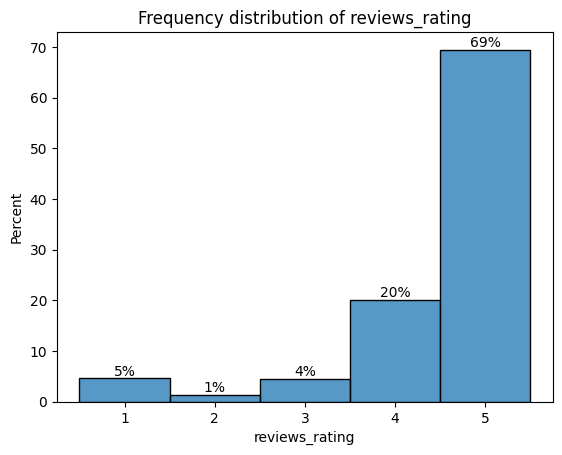

In [149]:
# Frequency plot of reviews_rating column
ax=sns.histplot(df_reviews['reviews_rating'],stat='percent',discrete='bool')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
plt.title("Frequency distribution of reviews_rating")

<Axes: xlabel='user_sentiment', ylabel='count'>

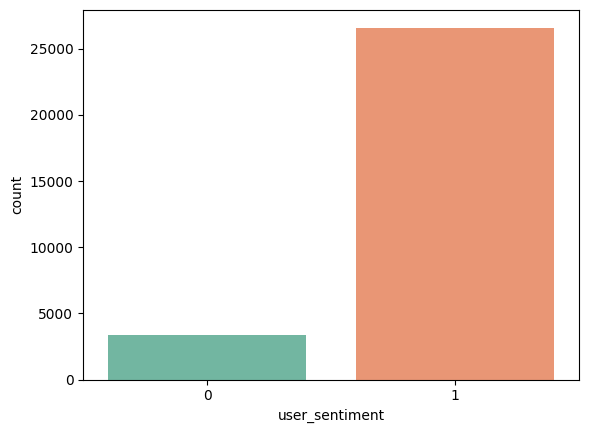

In [150]:

sns.countplot(x='user_sentiment', data= df_reviews, palette="Set2")

<Axes: xlabel='brand'>

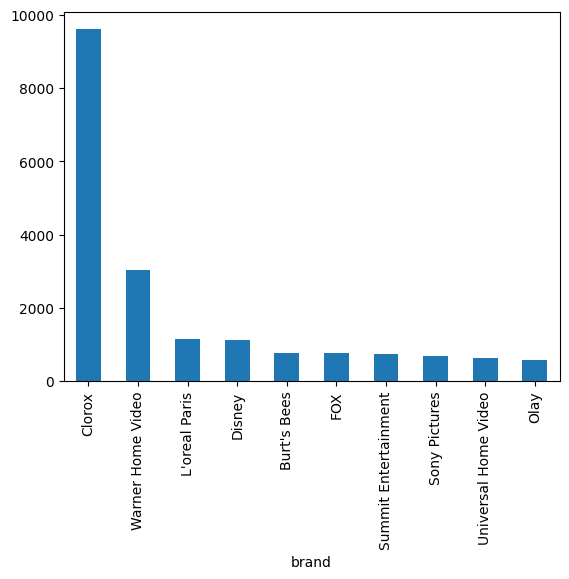

In [151]:
# Filter the top 10 brands among the positive sentiments
df_reviews[df_reviews['user_sentiment']==1].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar')

<Axes: xlabel='brand'>

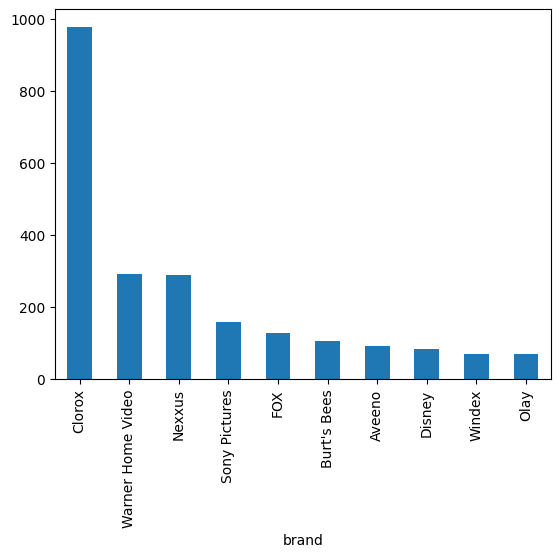

In [152]:
# Filter the top 10 brands among the negative sentiments
df_reviews[df_reviews['user_sentiment']==0].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar')

In [153]:
get_missing_value_percentage(df_reviews)

,missing_percentage
id,0.0
brand,0.0
categories,0.0
manufacturer,0.0
name,0.0
reviews_date,0.0
reviews_rating,0.0
reviews_text,0.0
reviews_title,0.0
reviews_username,0.0


In [154]:
df_reviews["reviews_full_text"] = df_reviews[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')

# **Task#2 Text Processing**

In [155]:
'''function to clean the text and remove all the unnecessary elements.'''
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub("\[\s*\w*\s*\]", "", text)
    dictionary = "abc".maketrans('', '', string.punctuation)
    text = text.translate(dictionary)
    text = re.sub("\S*\d\S*", "", text)

    return text

In [156]:
df_clean = df_reviews[['id','name', 'reviews_full_text', 'user_sentiment']]

In [157]:
df_clean["reviews_text"] = df_clean.reviews_full_text.apply(lambda x: clean_text(x))

In [158]:
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [159]:
stop_words = set(stopwords.words('english'))

In [160]:
def remove_stopword(text):
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)

In [161]:
lemmatizer = WordNetLemmatizer()
# Lemmatize the sentence
def lemma_text(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopword(text))) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(words)

In [162]:
df_clean["reviews_text_cleaned"] = df_clean.reviews_text.apply(lambda x: lemma_text(x))

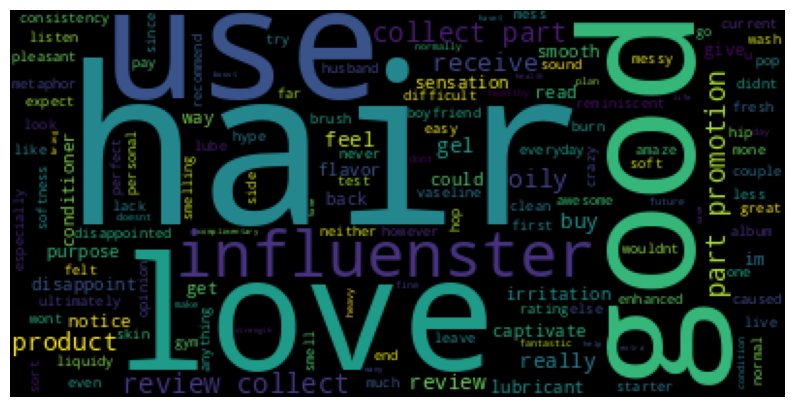

In [163]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stop_words,max_words=200).generate(str(df_clean.reviews_text_cleaned))

print(wordcloud)
plt.figure(figsize= (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

(array([1.1435e+04, 1.1719e+04, 3.8070e+03, 1.4660e+03, 6.9300e+02,
        3.1200e+02, 2.0800e+02, 1.0900e+02, 6.1000e+01, 3.9000e+01,
        3.3000e+01, 3.0000e+01, 6.0000e+00, 6.0000e+00, 6.0000e+00,
        5.0000e+00, 3.0000e+00, 2.0000e+00, 4.0000e+00, 2.0000e+00,
        5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   4.  ,   79.44,  154.88,  230.32,  305.76,  381.2 ,  456.64,
         532.08,  607.52,  682.96,  758.4 ,  833.84,  909.28,  984.72,
        1060.16, 1135.6 , 1211.04, 1286.48, 1361.92, 1437.36, 1512.8 ,
        1588.24, 1663.68, 1739.12, 1814.56, 1890.  , 1965.44, 2040.88,
        2116.32, 2191.76, 2267.2 ,

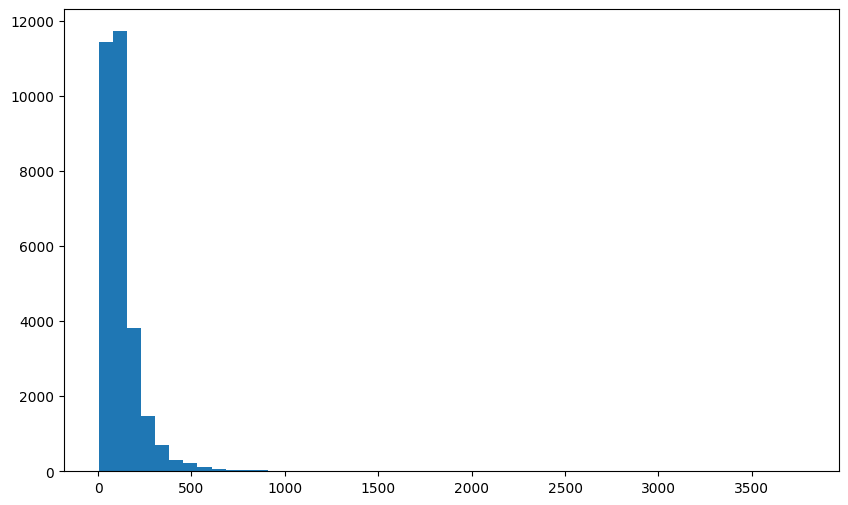

In [164]:
#visualise the data according to the 'Review Text' character length
plt.figure(figsize=(10,6))
reviews_lens = [len(d) for d in df_clean.reviews_text_cleaned]
plt.hist(reviews_lens, bins = 50)

In [167]:
from collections import Counter

In [168]:
def getMostCommonWords(reviews, n_most_common):
    # flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]


    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]


    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)

In [169]:
pos_reviews = df_clean[df_clean['user_sentiment']==1]
getMostCommonWords(pos_reviews['reviews_text_cleaned'],10)

[('great', 14494),
 ('love', 12433),
 ('use', 11982),
 ('product', 11395),
 ('movie', 10021),
 ('review', 8576),
 ('part', 8349),
 ('clean', 7982),
 ('promotion', 7946),
 ('wipe', 7619)]

In [170]:
neg_reviews = df_clean[df_clean['user_sentiment']==0]
getMostCommonWords(neg_reviews['reviews_text_cleaned'],10)

[('use', 1560),
 ('product', 1353),
 ('review', 900),
 ('part', 844),
 ('movie', 828),
 ('promotion', 802),
 ('collect', 750),
 ('wipe', 713),
 ('like', 710),
 ('love', 568)]

In [171]:
#function to collect the n-gram frequency of words
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [172]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(pos_reviews['reviews_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 2]]


,0,1
0,review collect,7520
1,collect promotion,7520
2,clorox wipe,2578
3,great product,1902
4,great movie,1701
5,easy use,1548
6,love clorox,1174
7,love product,1126
8,good movie,980
9,use clorox,949


In [173]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(neg_reviews['reviews_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 2]]


,0,1
0,review collect,748
1,collect promotion,748
2,clorox wipe,259
3,use product,177
4,old formula,172
5,new formula,163
6,use clorox,152
7,bring old,116
8,great product,111
9,resident evil,102


--1 [[1 1 1 ... 1 1 2]]


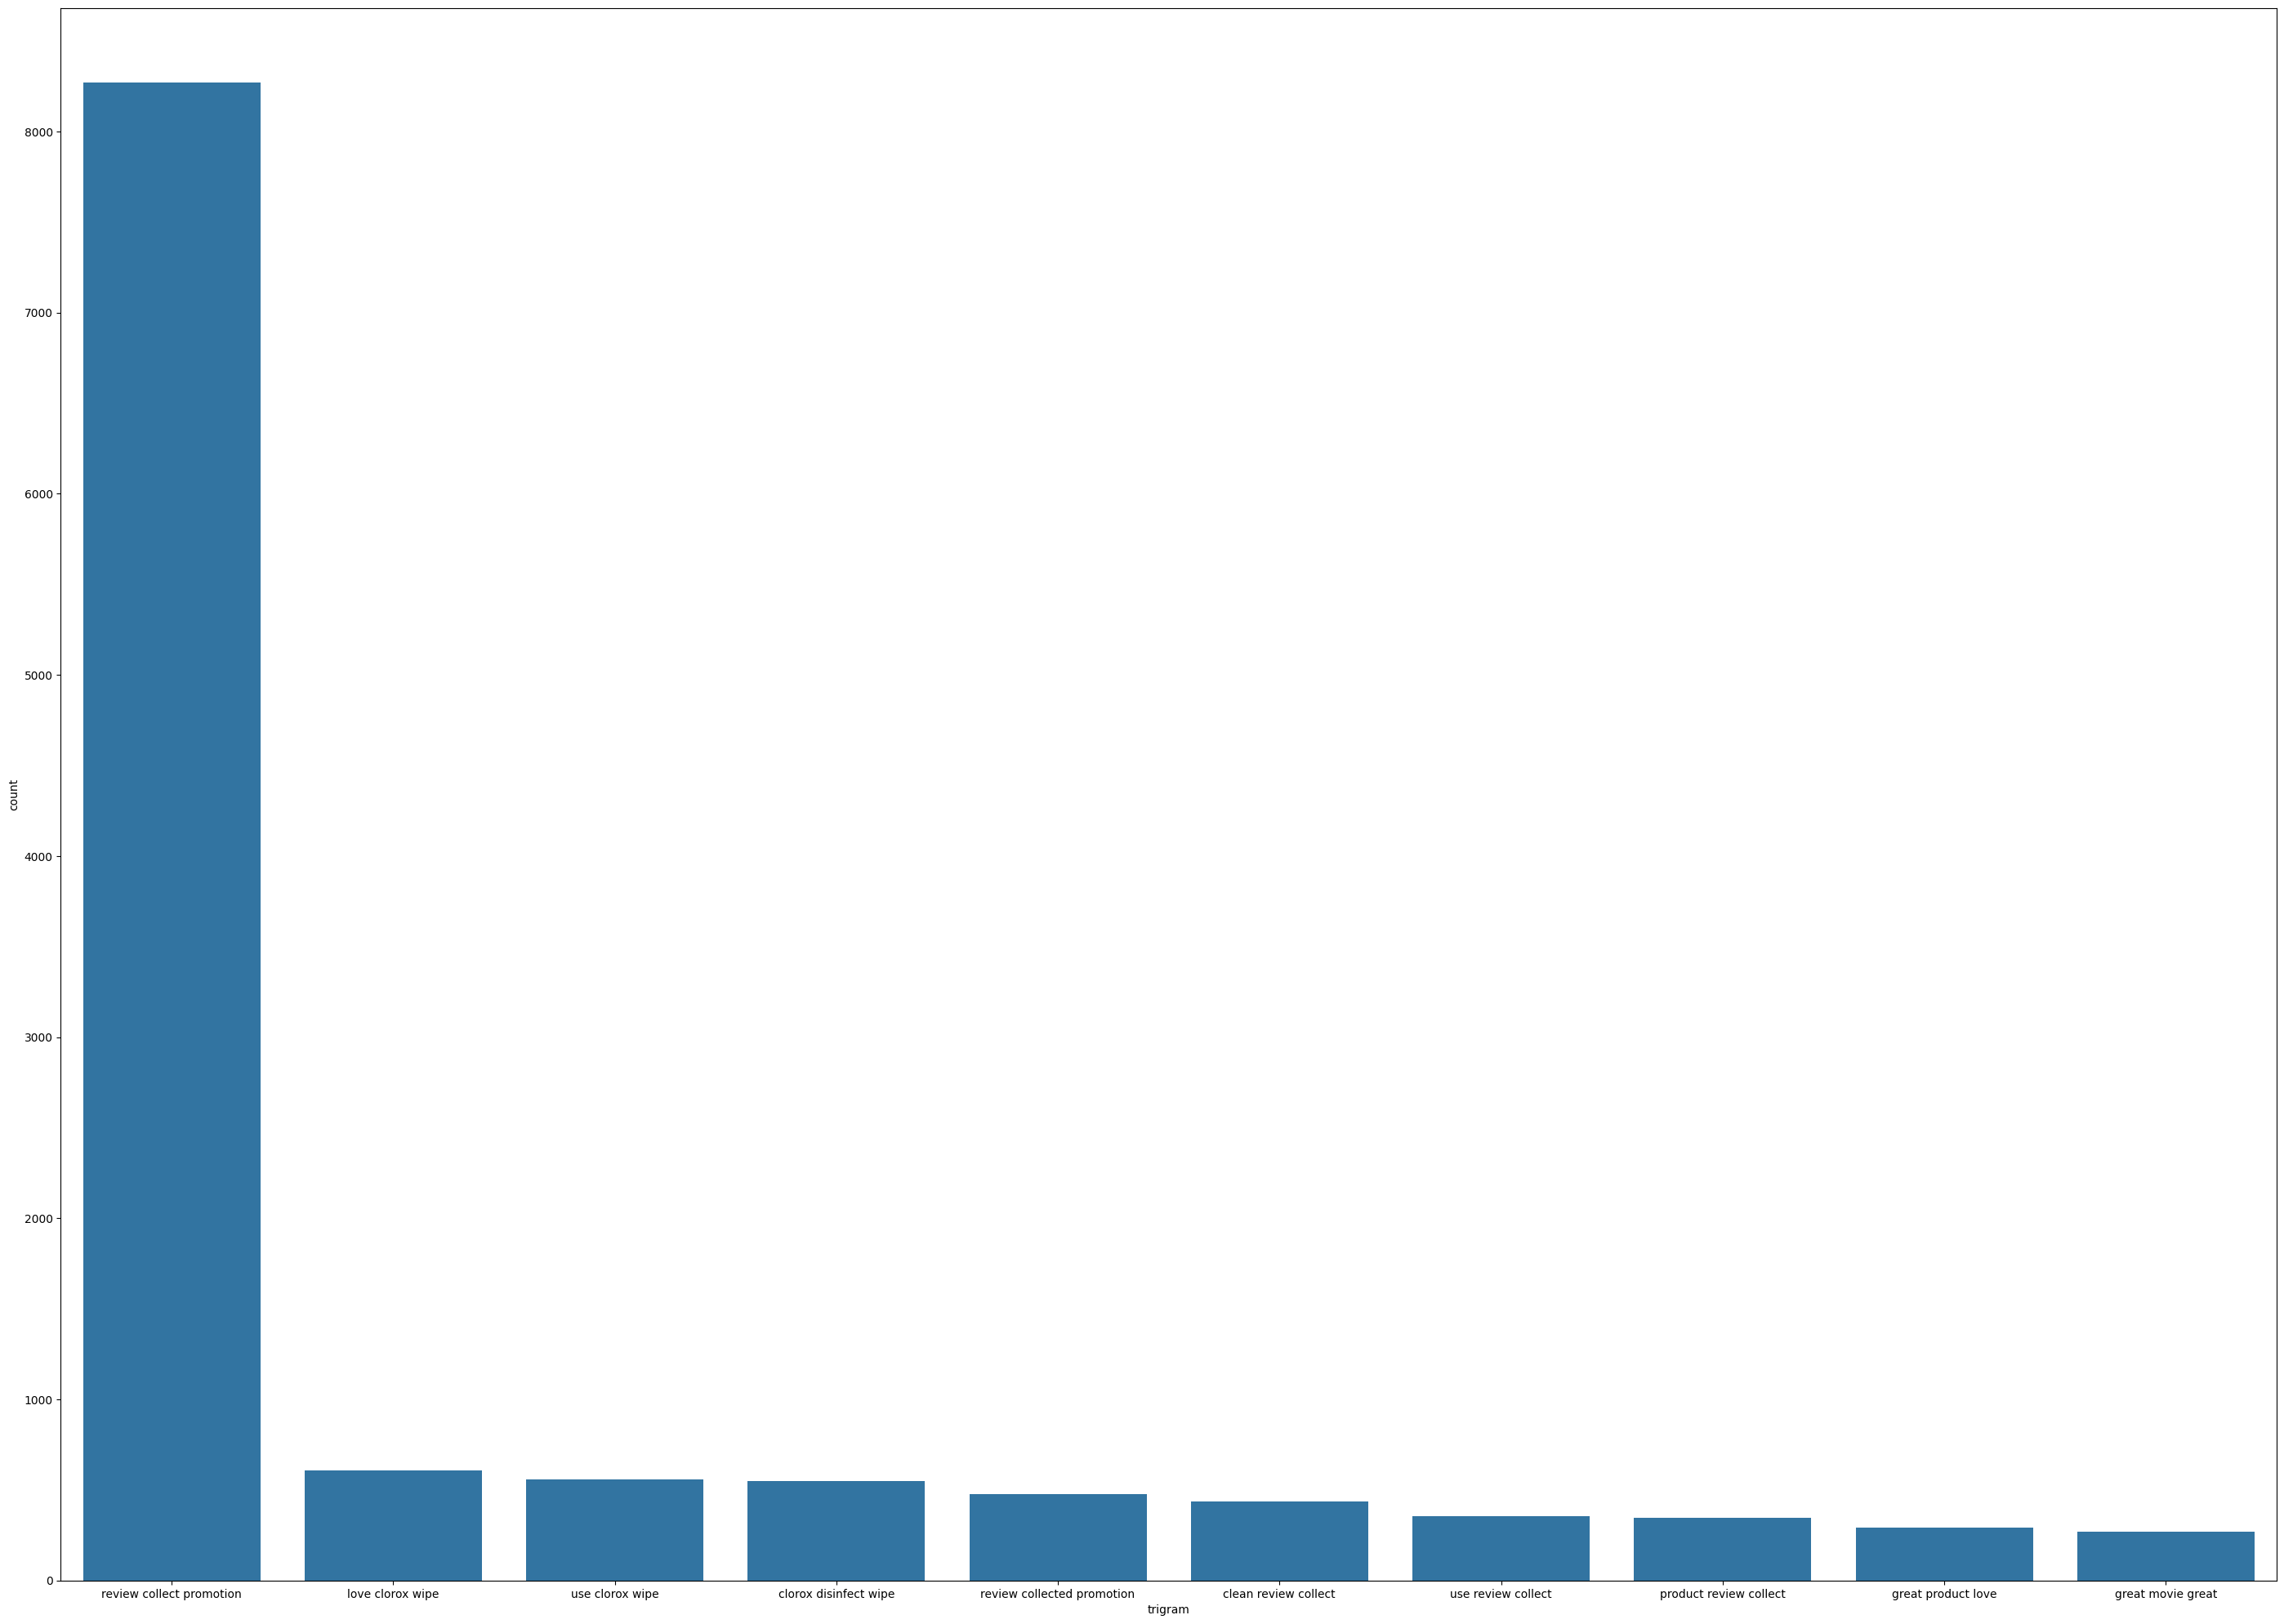

In [174]:
#logic to find the top 10 trigram frequency among the reviews_text in the cleaned datafram(df_clean).
common_words = get_top_n_ngram(df_clean.reviews_text_cleaned, 3, 10)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[35,25])
fig = sns.barplot(x=df3['trigram'], y=df3['count'])

In [175]:
X = df_clean['reviews_text_cleaned']
y = df_clean['user_sentiment']

# **Task#3 Feature Extraction**

In [176]:
no_of_classes= len(pd.Series(y).value_counts())

In [177]:
#Distribution of the target variable data in terms of proportions.
for i in range(0,no_of_classes):
    print("Percent of {0}s: ".format(i), round(100*pd.Series(y).value_counts()[i]/pd.Series(y).value_counts().sum(),2), "%")

Percent of 0s:  11.21 %
Percent of 1s:  88.79 %


In [178]:
#using TF-IDF vectorizer using the parameters to get 650 features.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True,
                                   ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_clean['reviews_text_cleaned'])

y= df_clean['user_sentiment']

In [179]:
print(tfidf_vectorizer.get_feature_names_out())

['able' 'absolutely' 'absolutely love' 'act' 'action' 'action movie'
 'actor' 'actually' 'add' 'age' 'ago' 'amaze' 'amazing' 'apply' 'area'
 'ask' 'available' 'away' 'awesome' 'awesome movie' 'awesome product'
 'awful' 'baby' 'bad' 'bag' 'bathroom' 'bathroom kitchen' 'beautiful'
 'bee' 'begin' 'believe' 'best' 'best buy' 'best product' 'big' 'bit'
 'black' 'bleach' 'blu' 'blu ray' 'bluray' 'body' 'bottle' 'box' 'boy'
 'brand' 'break' 'bring' 'bring cocoa' 'bring old' 'brown' 'burt'
 'burt bee' 'buy' 'canister' 'car' 'care' 'carpet' 'carry' 'cast' 'cd'
 'chair' 'change' 'character' 'cheap' 'child' 'chip' 'classic' 'classroom'
 'clay' 'clean' 'clean bathroom' 'clean disinfect' 'clean easy'
 'clean fresh' 'clean great' 'clean kitchen' 'clean love' 'clean mess'
 'clean product' 'clean review' 'clean smell' 'clean ups' 'clean use'
 'clean wipe' 'cleaner' 'cleaning' 'cleanup' 'clear' 'clorox'
 'clorox disinfect' 'clorox love' 'clorox product' 'clorox wipe' 'close'
 'cocoa' 'cold' 'collect' '

In [180]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=42, test_size=0.25)

### Class imbalance (using SMOTE) ###

In [182]:
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 19965, 0: 2500})
After Counter({1: 19965, 0: 19965})


# **Task#4 Model Buildling**

In [183]:
from sklearn import metrics
import pickle

In [184]:
class ModelBuilder:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test


    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)

    def evaluate_model(self, y_pred_class):
        print("\n")
        print("*"*30)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("*"*30)
        print("\n")

        self.classification_report(y_pred_class)
        print("*"*30)
        print("\n")
        self.confusion_matrix(y_pred_class)

        print("*"*30)
        print("\n")

        metrics.RocCurveDisplay.from_estimator(self.model, self.x_test, self.y_test)

        return self.result_metrics

    def evaluate_metrics(self, y_pred_class):
        result_metrics = []
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)

        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")

        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics

    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])


    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", fmt=".2%")

        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()

    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))

### Logistic Regression ###

In [186]:
# Build the Logistic Regression model.
%time
from sklearn.linear_model import LogisticRegression

logreg_ci = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")
lr_ci_modebuilder = ModelBuilder(logreg_ci, X_train, X_test, y_train, y_test)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.5 µs


In [187]:
# Train and Predict the Test Labels
y_pred_class  = lr_ci_modebuilder.train_model()



******************************
Accuracy is : 85.6%
Precision is : 95.4%
Recall is : 88.0%
F1 Score is : 91.6%
Roc-Auc Score is:88.5%
******************************


              precision    recall  f1-score   support

           0       0.42      0.67      0.52       858
           1       0.95      0.88      0.92      6631

    accuracy                           0.86      7489
   macro avg       0.69      0.78      0.72      7489
weighted avg       0.89      0.86      0.87      7489

******************************




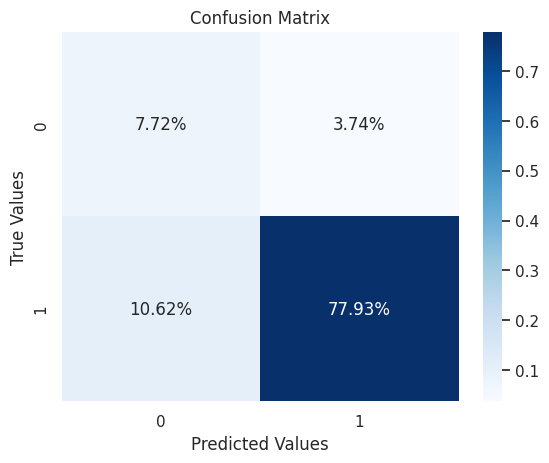

******************************




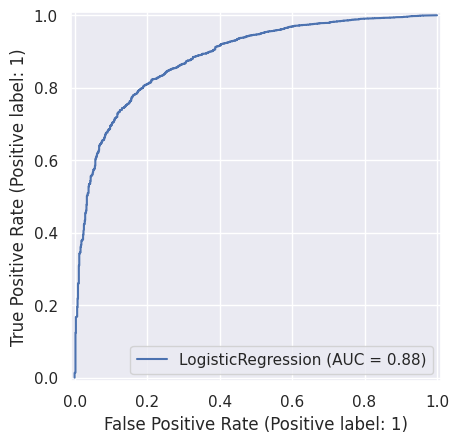

In [188]:
lr_metrics = lr_ci_modebuilder.evaluate_model(y_pred_class)

### Naive Bayes ###

In [189]:
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB

In [190]:
mnb = MultinomialNB(alpha=1.0)
mnb_modebuilder = ModelBuilder(mnb, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 79.4%
Precision is : 95.2%
Recall is : 80.8%
F1 Score is : 87.4%
Roc-Auc Score is:82.9%
******************************


              precision    recall  f1-score   support

           0       0.32      0.69      0.43       858
           1       0.95      0.81      0.87      6631

    accuracy                           0.79      7489
   macro avg       0.63      0.75      0.65      7489
weighted avg       0.88      0.79      0.82      7489

******************************




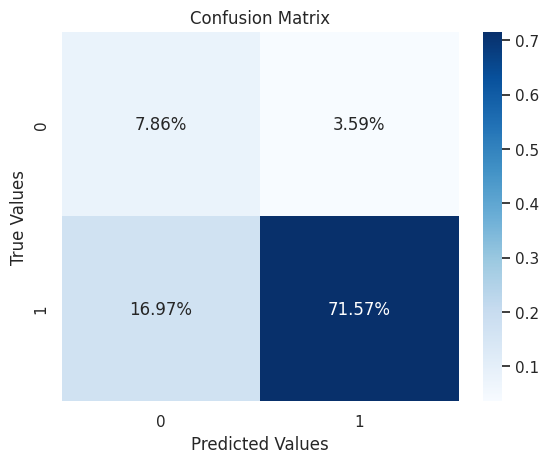

******************************




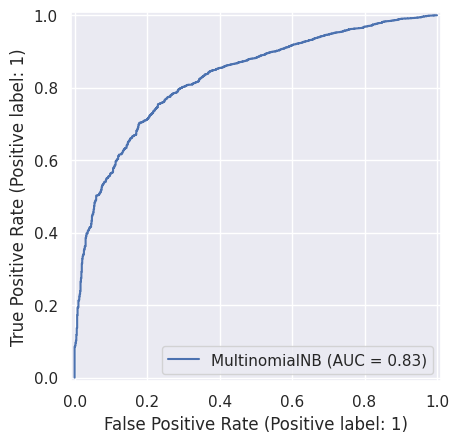

In [191]:
# Train and Predict the Test Labels
y_pred_class  = mnb_modebuilder.train_model()
nb_metrics = mnb_modebuilder.evaluate_model(y_pred_class)

### Decision Tree ###

In [192]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [193]:
dt = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)

In [194]:
dt_modelbuilder = ModelBuilder(dt, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 79.6%
Precision is : 93.8%
Recall is : 82.4%
F1 Score is : 87.7%
Roc-Auc Score is:77.2%
******************************


              precision    recall  f1-score   support

           0       0.30      0.58      0.39       858
           1       0.94      0.82      0.88      6631

    accuracy                           0.80      7489
   macro avg       0.62      0.70      0.64      7489
weighted avg       0.86      0.80      0.82      7489

******************************




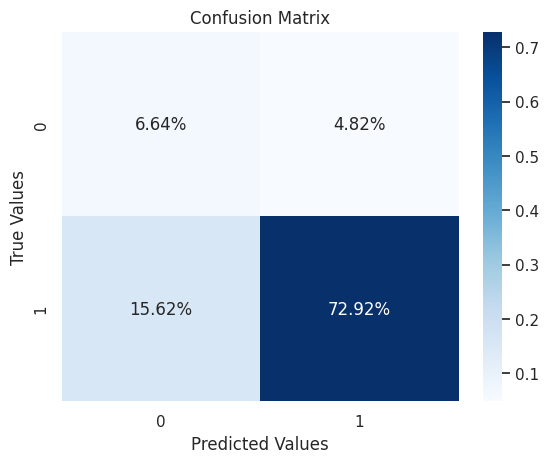

******************************




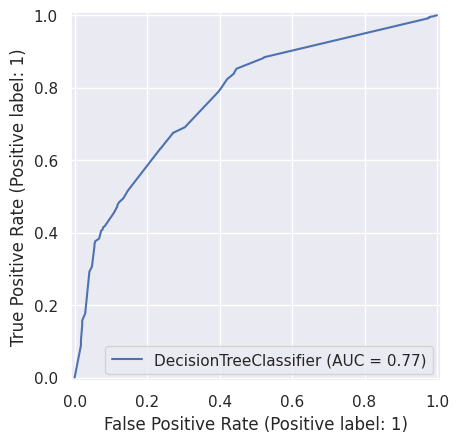

In [195]:
y_pred_class  = dt_modelbuilder.train_model()
dt_metrics_cv = dt_modelbuilder.evaluate_model(y_pred_class)

### Random Forrest ###

In [197]:
#Import the necessary module
from sklearn.ensemble import RandomForestClassifier

In [198]:
rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")

In [199]:
params = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [10, 25, 50, 100]
}

In [200]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1")

In [201]:
%time
grid_search.fit(X_train, y_train)

CPU times: user 67 µs, sys: 0 ns, total: 67 µs
Wall time: 75.3 µs
Fitting 4 folds for each of 64 candidates, totalling 256 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='f1', verbose=1)

In [202]:
rf_best = grid_search.best_estimator_
rf_modebuilder = ModelBuilder(rf_best, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 80.1%
Precision is : 94.5%
Recall is : 82.3%
F1 Score is : 88.0%
Roc-Auc Score is:82.0%
******************************


              precision    recall  f1-score   support

           0       0.31      0.63      0.42       858
           1       0.94      0.82      0.88      6631

    accuracy                           0.80      7489
   macro avg       0.63      0.73      0.65      7489
weighted avg       0.87      0.80      0.83      7489

******************************




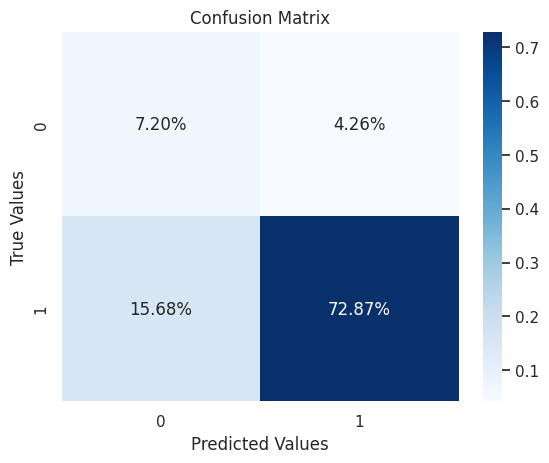

******************************




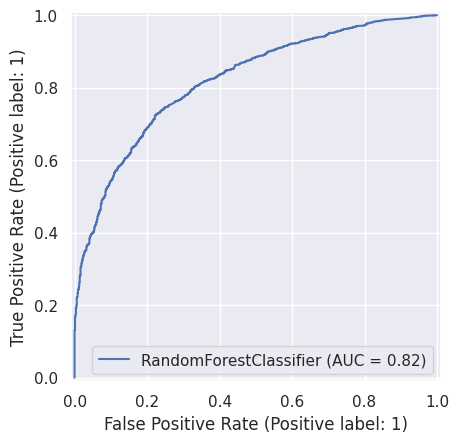

In [203]:
# Train and Predict the Test Labels
y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

### XGBoost Classifier ###

In [204]:
import xgboost as xgb

In [205]:
xgclf = xgb.XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42) #based on the tuned parameters
xg_modebuilder = ModelBuilder(xgclf, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 88.2%
Precision is : 94.6%
Recall is : 92.0%
F1 Score is : 93.3%
Roc-Auc Score is:88.5%
******************************


              precision    recall  f1-score   support

           0       0.49      0.59      0.54       858
           1       0.95      0.92      0.93      6631

    accuracy                           0.88      7489
   macro avg       0.72      0.76      0.73      7489
weighted avg       0.89      0.88      0.89      7489

******************************




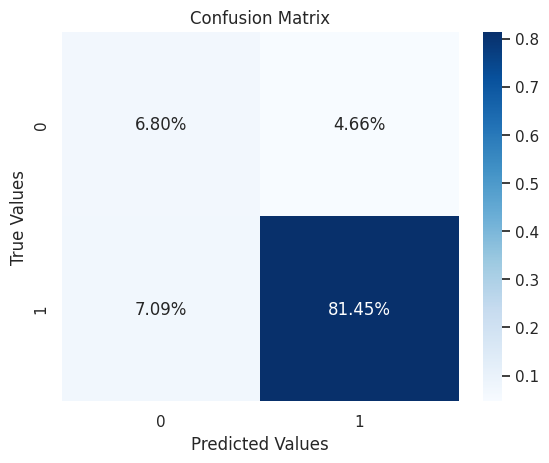

******************************




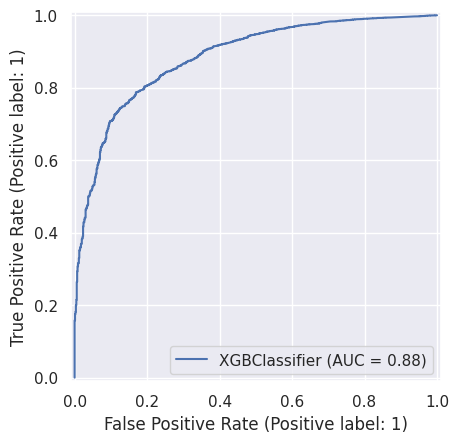

In [206]:
# Train and Predict the Test Labels
y_pred_class  = xg_modebuilder.train_model()
xg_metrics = xg_modebuilder.evaluate_model(y_pred_class)

In [207]:
# Creating a table which contain all the metrics

metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score','Auc Score'],
        'Logistic Regression': lr_metrics,
        'Naive Bayes': nb_metrics,
        'Decision Tree': dt_metrics_cv,
         'Random Forrest': rf_metrics,
        'XG Boost': xg_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Decision Tree','Random Forrest',
                                                    'XG Boost'] )

df_metrics

,Metric,Logistic Regression,Naive Bayes,Decision Tree,Random Forrest,XG Boost
0,Accuracy,0.86,0.79,0.80,0.80,0.88
1,Precision,0.95,0.95,0.94,0.94,0.95
2,Recall,0.88,0.81,0.82,0.82,0.92
3,F1Score,0.92,0.87,0.88,0.88,0.93
4,Auc Score,0.88,0.83,0.77,0.82,0.88


In [210]:
import os
import pickle

def save_object(obj, filename):
    # Create the 'pickle' directory if it doesn't exist
    os.makedirs("pickle", exist_ok=True)
    filename = "pickle/"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [211]:
save_object(xgclf, 'sentiment-classification-xg-boost-model')

In [212]:
save_object(tfidf_vectorizer, 'tfidf-vectorizer')

In [213]:
save_object(df_clean, 'cleaned-data')


# **Task#5 Recommendation System**